<a href="https://colab.research.google.com/github/salwaa-hub/newtubes_machinelearning/blob/main/newtubes_machinelearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TUGAS BESAR MACHINE LEARNING SEMESTER 4 - SALWA SALSABILA DAFFA'ATULHAQ (4.33.23.2.25)**

## **LSTM (Long Short-Term Memory)**

***Load & Eksplorasi Data Analisis***

>> Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Formatted Date            96453 non-null  object 
 1   Summary                   96453 non-null  object 
 2   Precip Type               95936 non-null  object 
 3   Temperature (C)           96453 non-null  float64
 4   Apparent Temperature (C)  96453 non-null  float64
 5   Humidity                  96453 non-null  float64
 6   Wind Speed (km/h)         96453 non-null  float64
 7   Wind Bearing (degrees)    96453 non-null  float64
 8   Visibility (km)           96453 non-null  float64
 9   Loud Cover                96453 non-null  float64
 10  Pressure (millibars)      96453 non-null  float64
 11  Daily Summary             96453 non-null  object 
dtypes: float64(8), object(4)
memory usage: 8.8+ MB
None

>> 5 Baris Pertama:
                  For

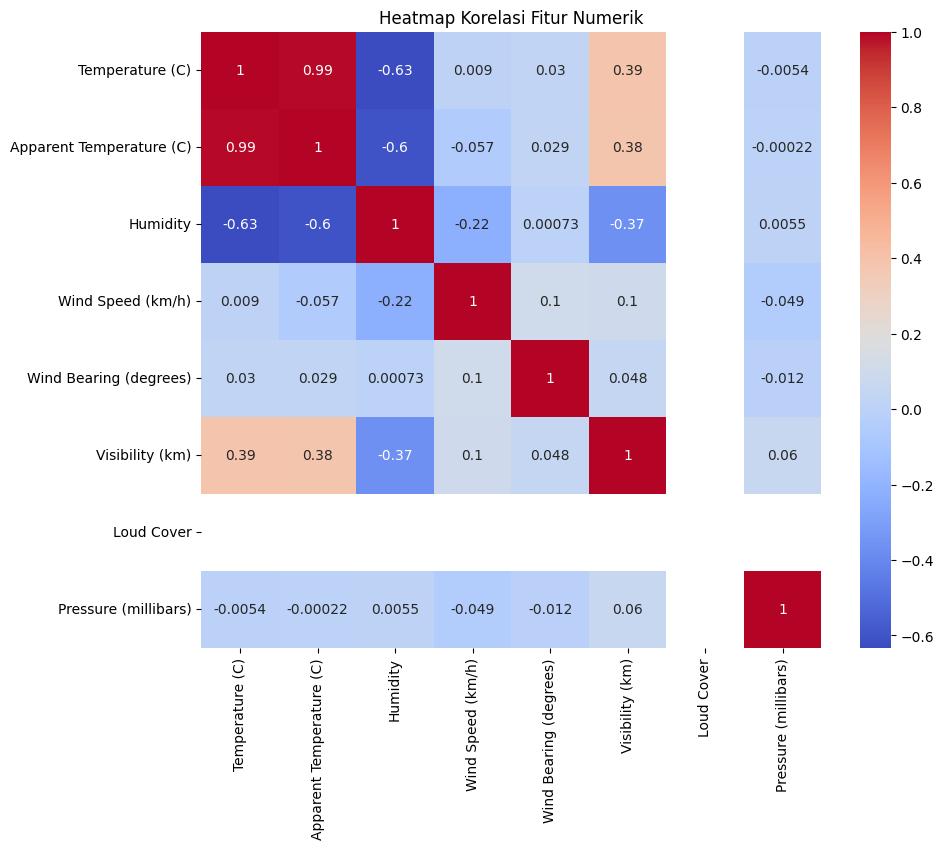


✅ Fitur yang dipilih berdasarkan korelasi (|corr| > 0.2) terhadap 'Temperature (C)':
['Apparent Temperature (C)', 'Humidity', 'Visibility (km)']


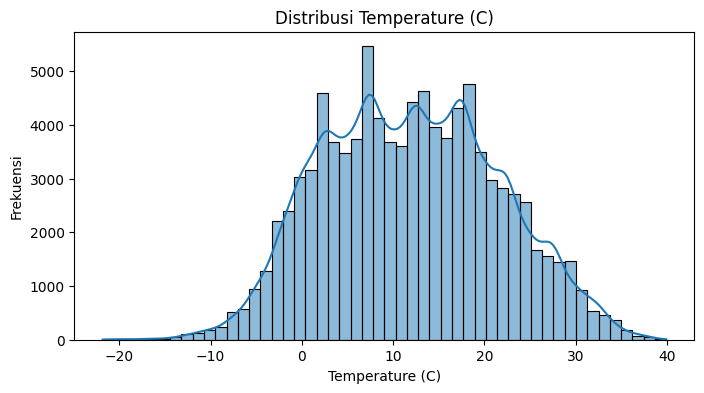


>> Range Waktu:
Mulai: 2005-12-31 23:00:00+00:00  ---  Selesai: 2016-12-31 22:00:00+00:00


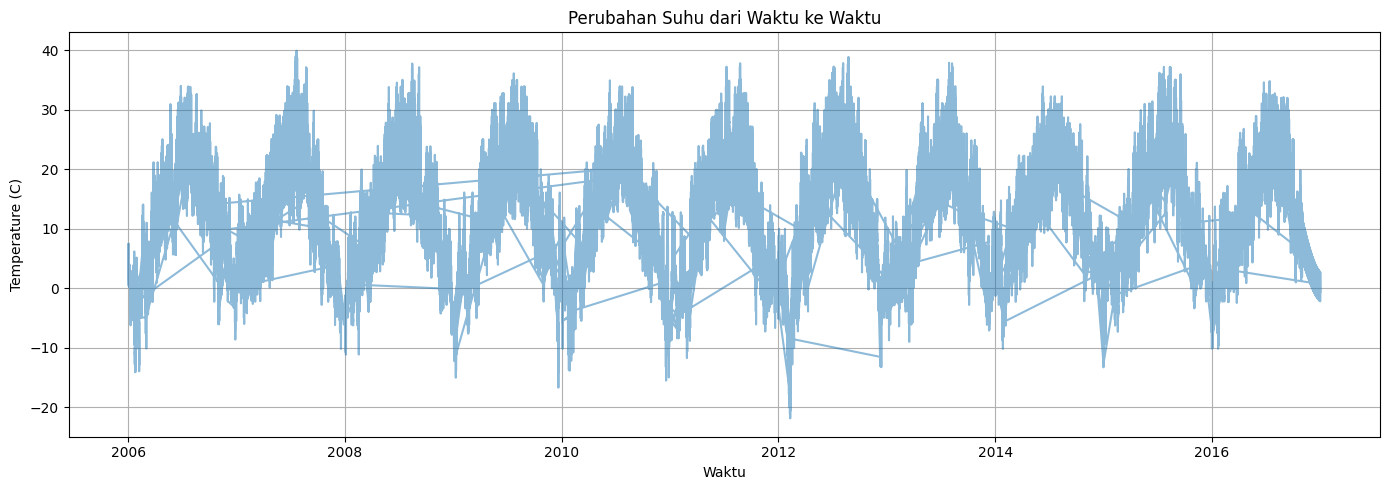

In [ ]:
# Install & Import library (jika perlu)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
url = '/content/weatherHistory.csv'
df = pd.read_csv(url)

# Info dataset
print(">> Informasi Dataset:")
print(df.info())
print("\n>> 5 Baris Pertama:")
print(df.head())

# Cek missing values
print("\n>> Missing Values Tiap Kolom:")
print(df.isnull().sum())

# Statistik deskriptif awal
print("\n>> Statistik Deskriptif:")
print(df.describe())

# Plot korelasi antar fitur numerik
plt.figure(figsize=(10, 8))
sns.heatmap(df.select_dtypes(include='float64').corr(), annot=True, cmap='coolwarm')
plt.title('Heatmap Korelasi Fitur Numerik')
plt.show()

# ====== Tambahan: Feature Selection berdasarkan korelasi dengan Temperature (C) ======
numeric_df = df.select_dtypes(include='float64')
correlation_matrix = numeric_df.corr()
target_corr = correlation_matrix["Temperature (C)"].abs().sort_values(ascending=False)

# Threshold korelasi minimum
threshold = 0.2
selected_features = target_corr[target_corr > threshold].index.tolist()

# Buang target dari daftar fitur input
if "Temperature (C)" in selected_features:
    selected_features.remove("Temperature (C)")

print("\n✅ Fitur yang dipilih berdasarkan korelasi (|corr| > 0.2) terhadap 'Temperature (C)':")
print(selected_features)

# Distribusi target (Temperature)
plt.figure(figsize=(8, 4))
sns.histplot(df['Temperature (C)'], bins=50, kde=True)
plt.title('Distribusi Temperature (C)')
plt.xlabel('Temperature (C)')
plt.ylabel('Frekuensi')
plt.show()

# Waktu sebagai datetime
df['Formatted Date'] = pd.to_datetime(df['Formatted Date'], utc=True)

# Cek range waktu
print("\n>> Range Waktu:")
print(f"Mulai: {df['Formatted Date'].min()}  ---  Selesai: {df['Formatted Date'].max()}")

# Plot garis suhu terhadap waktu
plt.figure(figsize=(14, 5))
plt.plot(df['Formatted Date'], df['Temperature (C)'], alpha=0.5)
plt.title('Perubahan Suhu dari Waktu ke Waktu')
plt.xlabel('Waktu')
plt.ylabel('Temperature (C)')
plt.grid(True)
plt.tight_layout()
plt.show()

***Preprocessing Data***

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Gunakan df dan selected_features dari Step 1
df_lstm = df[['Formatted Date', 'Temperature (C)'] + selected_features].copy()
df_lstm = df_lstm.sort_values('Formatted Date')  # sort by time

# ====== Normalisasi ======
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_lstm[selected_features + ['Temperature (C)']])
scaled_df = pd.DataFrame(scaled_data, columns=selected_features + ['Temperature (C)'])
scaled_df['Formatted Date'] = df_lstm['Formatted Date'].values  # tambahkan kembali waktu

# ====== Buat Window Time Series ======
def create_lstm_dataset(data, target_col, window_size=24):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i - window_size:i, :-1])  # semua fitur kecuali target
        y.append(data[i, -1])                   # target = Temperature (C)
    return np.array(X), np.array(y)

window_size = 24  # misalnya 24 jam sebelumnya
data_array = scaled_df[selected_features + ['Temperature (C)']].values

X, y = create_lstm_dataset(data_array, target_col='Temperature (C)', window_size=window_size)

print("✅ Bentuk akhir data:")
print("X shape:", X.shape)  # (samples, timesteps, features)
print("y shape:", y.shape)  # (samples,)

# ====== Split Train/Test ======
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False  # untuk time series, jangan di-shuffle!
)

print("\n✅ Split Data:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test :", X_test.shape, "y_test :", y_test.shape)

✅ Bentuk akhir data:
X shape: (96429, 24, 3)
y shape: (96429,)

✅ Split Data:
X_train: (77143, 24, 3) y_train: (77143,)
X_test : (19286, 24, 3) y_test : (19286,)


***Training Model LSTM***

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# ====== Bangun Arsitektur LSTM ======
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)  # output regresi
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

# ====== Training ======
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=64,
    verbose=1
)

# ====== Evaluasi ======
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"\n✅ MAE: {mae:.4f}")
print(f"✅ RMSE: {rmse:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 64)         │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,857 (116.63 KB)

 Trainable params: 29,857 (116.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
965/965 ━━━━━━━━━━━━━━━━━━━━ 31s 29ms/step - loss: 0.0098 - mae: 0.0712 - val_loss: 0.0010 - val_mae: 0.0251
Epoch 2/20
965/965 ━━━━━━━━━━━━━━━━━━━━ 43s 31ms/step - loss: 0.0027 - mae: 0.0410 - val_loss: 0.0011 - val_mae: 0.0258
Epoch 3/20
965/965 ━━━━━━━━━━━━━━━━━━━━ 39s 28ms/step - loss: 0.0017 - mae: 0.0325 - val_loss: 7.6681e-04 - val_mae: 0.0219
Epoch 4/20
965/965 ━━━━━━━━━━━━━━━━━━━━ 27s 28ms/step - loss: 0.0013 - mae: 0.0279 - val_loss: 7.1776e-04 - val_mae: 0.0212
Epoch 5/20
965/965 ━━━━━━━━━━━━━━━━━━━━ 41s 28ms/step - loss: 0.0010 - mae: 0.0251 - val_loss: 9.2187e-04 - val_mae: 0.0245
Epoch 6/20
965/965 ━━━━━━━━━━━━━━━━━━━━ 41s 28ms/step - loss: 9.7053e-04 - mae: 0.0241 - val_loss: 5.0839e-04 - val_mae: 0.0174
Epoch 7/20
965/965 ━━━━━━━━━━━━━━━━━━━━ 43s 30ms/step - loss: 9.1947e-04 - mae: 0.0233 - val_loss: 5.7608e-04 - val_mae: 0.0186
Epoch 8/20
965/965 ━━━━━━━━━━━━━━━━━━━━ 38s 28ms/step - loss: 8.9711e-04 - mae: 0.0230 - val_loss: 5.0567e-04 - val_mae: 0.0176
Epoc

***Evaluasi Prediksi***

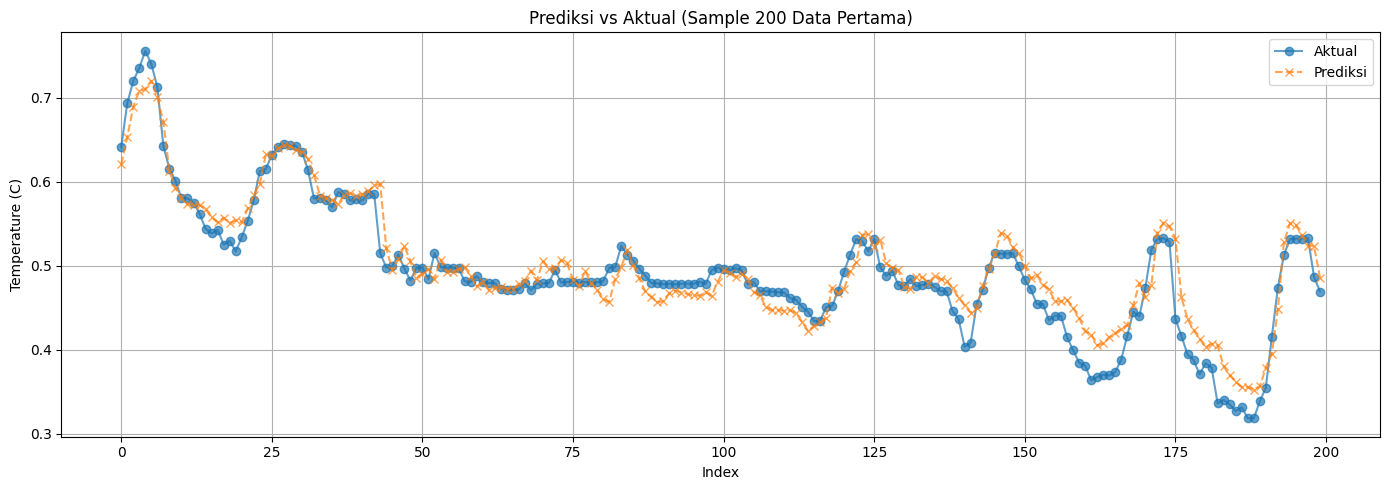

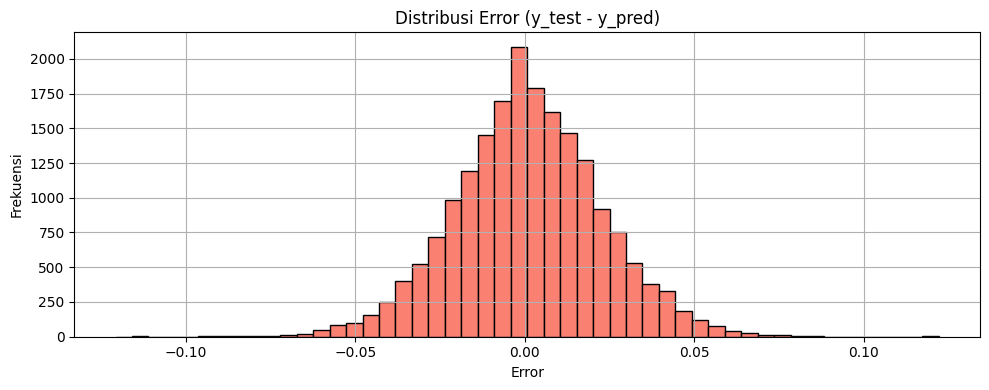

In [ ]:
import matplotlib.pyplot as plt

# ====== 1. Plot Prediksi vs Aktual ======
plt.figure(figsize=(14, 5))
plt.plot(y_test[:200], label='Aktual', marker='o', linestyle='-', alpha=0.7)
plt.plot(y_pred[:200], label='Prediksi', marker='x', linestyle='--', alpha=0.7)
plt.title('Prediksi vs Aktual (Sample 200 Data Pertama)')
plt.xlabel('Index')
plt.ylabel('Temperature (C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ====== 2. Plot Error (Residuals) ======
error = y_test - y_pred.flatten()

plt.figure(figsize=(10, 4))
plt.hist(error, bins=50, color='salmon', edgecolor='black')
plt.title('Distribusi Error (y_test - y_pred)')
plt.xlabel('Error')
plt.ylabel('Frekuensi')
plt.grid(True)
plt.tight_layout()
plt.show()

***Visualisasi Training Loss dan Validation Loss***

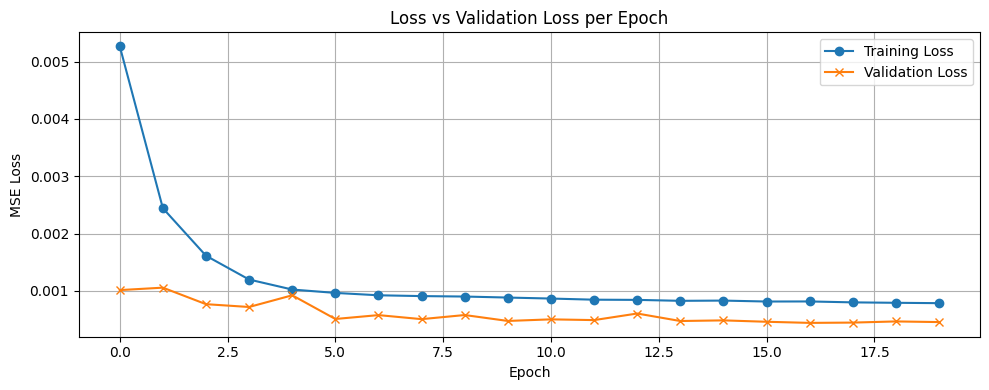

In [ ]:
import matplotlib.pyplot as plt

# Ambil data dari history
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot
plt.figure(figsize=(10, 4))
plt.plot(loss, label='Training Loss', marker='o')
plt.plot(val_loss, label='Validation Loss', marker='x')
plt.title('Loss vs Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

***K-FOLD***

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import numpy as np

n_splits = 5  # jumlah fold
tscv = TimeSeriesSplit(n_splits=n_splits)

mae_list = []
rmse_list = []

for fold, (train_index, test_index) in enumerate(tscv.split(X)):
    print(f"\n======= Fold {fold+1} =======")

    X_train_fold, X_test_fold = X[train_index], X[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]

    # Bangun ulang model untuk tiap fold
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(X_train_fold.shape[1], X_train_fold.shape[2])),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    # Training
    history = model.fit(
        X_train_fold, y_train_fold,
        validation_split=0.2,
        epochs=20,
        batch_size=64,
        verbose=0  # supaya output tidak panjang
    )

    # Evaluasi
    y_pred_fold = model.predict(X_test_fold)
    mae = mean_absolute_error(y_test_fold, y_pred_fold)
    rmse = np.sqrt(mean_squared_error(y_test_fold, y_pred_fold))

    print(f"MAE  Fold {fold+1}: {mae:.4f}")
    print(f"RMSE Fold {fold+1}: {rmse:.4f}")

    mae_list.append(mae)
    rmse_list.append(rmse)

# Rata-rata performa
print("\n======= Rata-rata Hasil K-Fold =======")
print(f"Rata-rata MAE : {np.mean(mae_list):.4f}")
print(f"Rata-rata RMSE: {np.mean(rmse_list):.4f}")


======= Fold 1 =======


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


503/503 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
MAE  Fold 1: 0.0208
RMSE Fold 1: 0.0267

======= Fold 2 =======


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


503/503 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
MAE  Fold 2: 0.0187
RMSE Fold 2: 0.0246

======= Fold 3 =======


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


503/503 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
MAE  Fold 3: 0.0177
RMSE Fold 3: 0.0231

======= Fold 4 =======


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


503/503 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
MAE  Fold 4: 0.0175
RMSE Fold 4: 0.0226

======= Fold 5 =======


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


503/503 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
MAE  Fold 5: 0.0167
RMSE Fold 5: 0.0217

======= Rata-rata Hasil K-Fold =======
Rata-rata MAE : 0.0183
Rata-rata RMSE: 0.0237


## TFT (Temporal Fusion Transformer)

***Load & EDA***

In [ ]:
# === Install library tambahan jika diperlukan ===
!pip install -q pytorch-lightning==1.9.0
!pip install -q pytorch-forecasting

# === Import Library ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch Forecasting & Time Series Specific
import torch
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, Baseline
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor

# === Load Dataset ===
df = pd.read_csv('/content/weatherHistory.csv')

# Pastikan kolom waktu dalam format datetime
df['Formatted Date'] = pd.to_datetime(df['Formatted Date'], utc=True)

# Sort berdasarkan waktu
df = df.sort_values("Formatted Date")

# Tampilkan ringkasan awal
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
Index: 96453 entries, 2880 to 89732
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   Formatted Date            96453 non-null  datetime64[ns, UTC]
 1   Summary                   96453 non-null  object             
 2   Precip Type               95936 non-null  object             
 3   Temperature (C)           96453 non-null  float64            
 4   Apparent Temperature (C)  96453 non-null  float64            
 5   Humidity                  96453 non-null  float64            
 6   Wind Speed (km/h)         96453 non-null  float64            
 7   Wind Bearing (degrees)    96453 non-null  float64            
 8   Visibility (km)           96453 non-null  float64            
 9   Loud Cover                96453 non-null  float64            
 10  Pressure (millibars)      96453 non-null  float64            
 11  Daily Summary    